# price

In [24]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the dataset
file_path = 'MarketPricePrediction.csv'
data = pd.read_csv(file_path)

# Convert date column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%B-%Y')

# Set the date column as the index
data.set_index('date', inplace=True)

# Dropping unnecessary columns
data = data[['priceMod']]

# Display the first few rows of the dataset
data.head()


,priceMod
date,
2005-01-01,446
2006-01-01,563
2010-01-01,1460
2011-01-01,3433
2012-01-01,605


In [3]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, Y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)


In [9]:
len(X)

10216

In [10]:

X_train, X_val ,X_test = X[0:7151], X[7151:9500],X[9500:]
Y_train, Y_val , Y_test = Y[0:7151], Y[7151:9500],Y[9500:]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((7151, 10, 1), (716, 10, 1), (7151,), (716,))

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=1, verbose=1)


Epoch 1/10


c:\Users\iT\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7151/7151 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0157 - val_loss: 0.0112
Epoch 2/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 3/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0124 - val_loss: 0.0107
Epoch 4/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0117 - val_loss: 0.0103
Epoch 5/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0114 - val_loss: 0.0097
Epoch 6/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0101 - val_loss: 0.0091
Epoch 7/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0099 - val_loss: 0.0088
Epoch 8/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 9/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 10/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0075 - val_loss: 0.0088


In [12]:
test_evaluate = model.evaluate(X_test, Y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0098 


In [13]:
train_evaluate = model.evaluate(X_train, Y_train)

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090


In [18]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':Y_train})
train_results

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,Train Predictions,Actuals
0,0.216965,0.196519
1,0.125251,0.165348
2,0.205347,0.077532
3,0.214762,0.245095
4,0.210717,0.142880
...,...,...
7146,0.129356,0.121835
7147,0.152794,0.034494
7148,0.112380,0.058544
7149,0.129390,0.018354


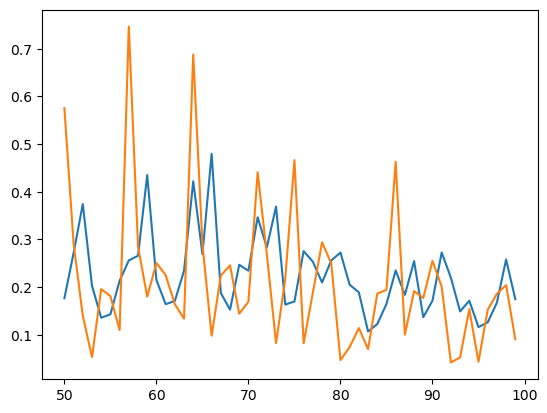

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [21]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals(test)':Y_test})
test_results

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Test Predictions,Actuals(test)
0,0.063903,0.024525
1,0.109777,0.089557
2,0.063774,0.056487
3,0.102340,0.056646
4,0.131671,0.118829
...,...,...
711,0.228511,0.276899
712,0.186504,0.070570
713,0.160815,0.167089
714,0.208272,0.173576


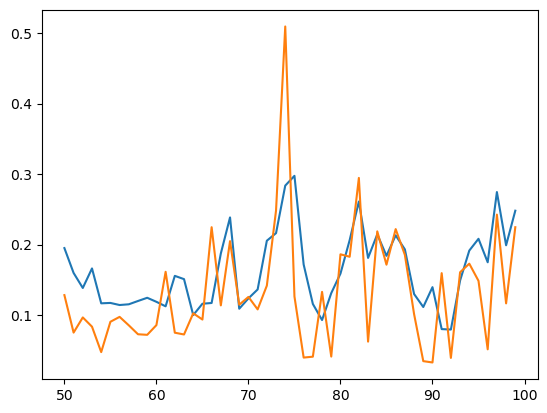

In [22]:

plt.plot(test_results['Test Predictions'][50:100])
plt.plot(test_results['Actuals(test)'][50:100])

# quantity


In [26]:

# Load the dataset
file_path = 'MarketPricePrediction.csv'
data = pd.read_csv(file_path)

# Convert date column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%B-%Y')

# Set the date column as the index
data.set_index('date', inplace=True)

# Dropping unnecessary columns
data = data[['quantity']]

# Display the first few rows of the dataset
data.head()

,quantity
date,
2005-01-01,2350
2006-01-01,900
2010-01-01,790
2011-01-01,245
2012-01-01,1035


In [27]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [28]:

X_train, X_val ,X_test = X[0:7151], X[7151:9500],X[9500:]
Y_train, Y_val , Y_test = Y[0:7151], Y[7151:9500],Y[9500:]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((7151, 10, 1), (716, 10, 1), (7151,), (716,))

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=1, verbose=1)


Epoch 1/10


c:\Users\iT\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7151/7151 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0149 - val_loss: 0.0117
Epoch 2/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.0128 - val_loss: 0.0110
Epoch 3/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.0130 - val_loss: 0.0103
Epoch 4/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.0117 - val_loss: 0.0100
Epoch 5/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0113 - val_loss: 0.0095
Epoch 6/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.0104 - val_loss: 0.0094
Epoch 7/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.0096 - val_loss: 0.0110
Epoch 8/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 9/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 10/10
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0078 - val_loss: 0.0078


In [30]:
test_evaluate = model.evaluate(X_test, Y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0080  


In [31]:
train_evaluate = model.evaluate(X_train, Y_train)

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074


In [32]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':Y_train})
train_results

224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


,Train Predictions,Actuals
0,0.094961,0.196519
1,0.148708,0.165348
2,0.162875,0.077532
3,0.213912,0.245095
4,0.187298,0.142880
...,...,...
7146,0.110187,0.121835
7147,0.140479,0.034494
7148,0.053064,0.058544
7149,0.101403,0.018354


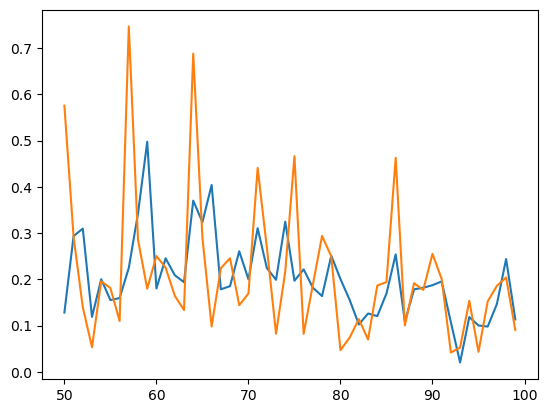

In [33]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [34]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals(test)':Y_test})
test_results

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Test Predictions,Actuals(test)
0,0.062705,0.024525
1,0.131388,0.089557
2,0.060615,0.056487
3,0.122584,0.056646
4,0.115541,0.118829
...,...,...
711,0.194707,0.276899
712,0.120251,0.070570
713,0.141633,0.167089
714,0.203804,0.173576


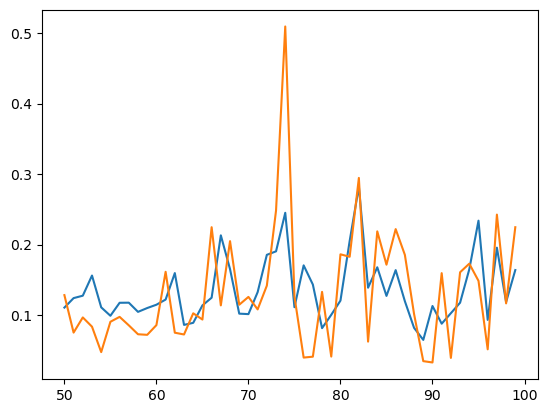

In [35]:

plt.plot(test_results['Test Predictions'][50:100])
plt.plot(test_results['Actuals(test)'][50:100])